In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal

%matplotlib inline
from matplotlib import pyplot, image, colors
from shapely.geometry import Polygon
np.random.seed(10)

In [28]:
# read image
img_path = './msi_til_maps/Stomach_Cancer_Stage4_Immunotherapy/SS1668384_binary.png'
img = image.imread(img_path)
height, width, channel = img.shape
# set grid 
grid = 5
n_neighbors = 10
cols = list(range(0, width, grid))
rows = list(range(0, height, grid))
rows.reverse()
# find tumor, lympho, msi, and bounding points
polygons = []
n_tumor = []
n_lympho = []
n_msi = []
for x in cols:
    org_y = 0
    for y in rows:
        polygons.append(Polygon([(x, y), (x+grid, y), (x+grid, y-grid), (x, y-grid)])) 
        # get the number of lymphocyates in a grid
        lympho = img[org_y:org_y+grid, x:x+grid, 0]
        n_lympho.append(len(lympho[lympho>0]))
        # get the number of tumor in a grid
        tumor = img[org_y:org_y+grid, x:x+grid, 2]
        n_tumor.append(len(tumor[tumor>0]))
        # get the number of msi in a grid but only inside tumor
        msi = img[org_y:org_y+grid, x:x+grid, 1]
        n_msi.append(sum(msi[np.where(tumor>0)]>0))
        org_y += grid
# create dataframe
img_df = gpd.GeoDataFrame({'lympho':n_lympho, 'tumor':n_tumor, 'msi':n_msi, 'geometry':polygons})

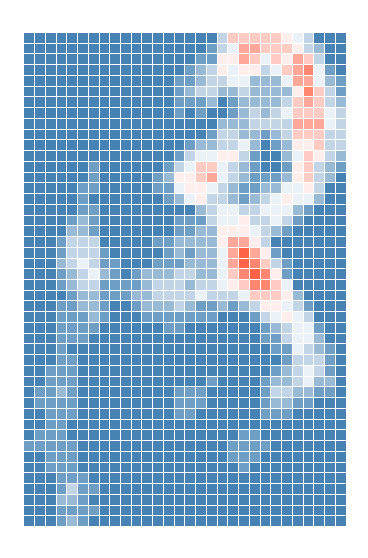

In [29]:
# compute neighbors
neighbors = pysal.lib.weights.distance.KNN.from_dataframe(img_df, k=n_neighbors) 
# compute Getis Ords Gi* for lympho
getis_ord_gi = pysal.explore.esda.G_Local(img_df['lympho'], neighbors, transform='B')
# add z-score to the dataframe 
img_df['z-score'] = getis_ord_gi.Zs
# remove nan values
img_df['z-score'] = img_df['z-score'].replace(np.nan, 0)
# create color scale
cmap = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', ["steelblue", "white", "tomato"], 10)

# plot 
fig, ax = pyplot.subplots(1, figsize=(10,10))
img_df.plot(cmap=cmap, ax=ax, column='z-score', edgecolor='1.0')
# turn off bounding box
tmp = ax.axis('off')
        